# How to Train Your Relational Fusion Network
This notebook gives a brief overview on how to define and train Relational Fusion Networks (RFNs) [1]. You may find an extended arXiv preprint of the paper [here](https://arxiv.org/abs/1908.11567).

The implementation relies on the deep learning framework [MXNet](https://mxnet.incubator.apache.org/), but familiarity with other deep learning frameworks should be sufficient to understand this tutorial. If you are not familiar with any deep learning framework, consider reading [MXNet's tutorial]](https://beta.mxnet.io/guide/crash-course/index.html) on their Gluon API which is used in this library.

## Example Data and Data Processing
An RFN requires a graph representation of a network along with feature matrices for the node, edge, and between-edge features. Between-edge features in this case refers to features that describe the relationship between two edges. In our paper, we use, e.g., the angle between two road segments represented as edges. However, to keep this tutorial rief, we generate random features.

We illustrate how to use the library through a simple graph example: the three-way intersection illustrated to the right in Fig. 2 in [1]. 

### Input Graph Definitions
We now create primal and dual graph representations of the intersection.

In this example we use the easy-to-use graph library `networkx`. Consider using the `python-igraph` library for large graphs.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(G, pos={}):
    if not pos:
        pos = nx.spring_layout(G)
    
    nx.draw_networkx_nodes(G, pos, node_size = 500)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, arrows=True)
    plt.axis('off')
    plt.show()

### Primal Graph Defintion
In the primal graph, nodes represent intersections and edges represent road segments. Using the `networkx` library we only have to add the road segments as edges; the source and target nodes of an edge are implicitly added if they are missing.

/home/juhyeon/anaconda3/envs/roadnetwork/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/juhyeon/anaconda3/envs/roadnetwork/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


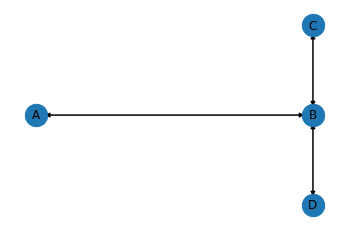

In [2]:
primal_graph = nx.DiGraph()

primal_graph.add_edge('A', 'B')
primal_graph.add_edge('B', 'A')

primal_graph.add_edge('B', 'C')
primal_graph.add_edge('C', 'B')

primal_graph.add_edge('B', 'D')
primal_graph.add_edge('D', 'B')

pos = {
    'A': (-1, 0),
    'B': (0, 0),
    'C': (0, 1),
    'D': (0, -1)}

plot_graph(primal_graph, pos)

### Dual Graph Representation
We can now convert the primal graph to a dual graph. In the dual graph, the road segments (edges in the primal graph) become nodes and edges in the dual graph, which we refer to as between-edges, indicate that two edges are connected through a node.

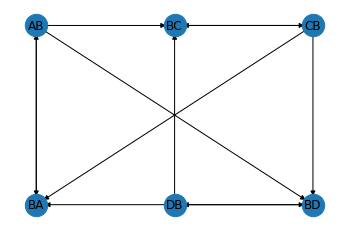

In [3]:
dual_graph = nx.DiGraph()
dual_graph.add_nodes_from(
    ''.join(edge)
    for edge in primal_graph.edges
)

for in_edge in primal_graph.edges():
    in_source, in_target = in_edge
    for out_target in primal_graph.successors(in_target):
        dual_graph.add_edge(
            ''.join(in_edge),
            ''.join([in_target, out_target])
        )

pos = {
    'AB': (0, 0),
    'BA': (0, -1),
    'BC': (1, 0),
    'DB': (1, -1),
    'CB': (2, 0),
    'BD': (2, -1)
}
plot_graph(dual_graph, pos)

## Data Preprocessing
To utilize the highly-optimised tensor operations in the MXNet deep learning library, we  first format the primal and dual graphs as matrices.

In [4]:
from itertools import chain
from mxnet import ndarray as nd
import numpy as np
from pprint import pprint

### Building Neighborhood Matrices
The main idea for building the neighborhood matrices is to convert each graph into an adjacency list in matrix format.
Such a matrix is of size $|V| \times N_{\mathit{max}}$, where $N_{\mathit{max}}$ is the maximum number of neighbors of a node has in the graph.

Not all nodes have the maximum number of neighbors. We therefore also compute a mask that the implementation uses to ignore entries in the matrix-formatted adjacency list.
RFNs also use information from the edges that connect them to the neighbors. We therefore also compute an edge-adjacency list in the same manner. See the function below for details.

In [5]:
def make_neighborhood_matrices(graph, node_indices, edge_indices,
                               is_dual=False, node_indices_primal=None):
    """
        Converts a graph into node and edge the required neighborhood matrices with asso

        Args:
            graph: A networkx primal or dual graph presentation of a road network.
            node_indices: A map from node objects in the graph to node indexes in
                          the output node neighborhood matrix N_node.
            edge_indices: A map from edge objects in the graph to edge indexes in
                          the output edge neighborhood matrix N_edge.
            is_dual: Boolean flag that indicates whether the graph is a dual graph.
            node_indices_primal: Must be supplied if is_dual is True.
                                 Maps node objects in the primal graph to node indexes in
                                 the common node neighborhood matrix N_common_node.
        Returns:
            N_node: A node adjacency list in matrix format.
                    The ith row contains the node indices of the nodes
                    in the neighborhood of the ith node. of the ith node.
            N_edge: A node adjacency list in matrix format.
                    The ith row contains the edge indices of the edges connecting the ith
                    node to its neighbors.
            N_mask: A matrix that indicates whether the jth entry in N_node or N_edge 
                    exists in the graph.
            N_common_node: Only returned if is_dual=True.
                           A common node is a node that is common to the two edges
                           connected by a between-edge. The ith row and jth column in 
                           this matrix contains the index of the common node that connects 
                           ith edge (a node in the dual graph) is connected to its jth neighbor.
            N_common_mask: Only returned if is_dual=True.
                           Similar to N_mask, N_common_mask indicates whether the jth entry in
                           N_common_node exists in the graph.
                           
        Raises:
            KeyError: Raises an exception.
    """
    assert not is_dual or is_dual and node_indices_primal is not None
    N_node = []
    N_edge = []
    
    nodes = sorted(
        list(graph.nodes()),
        key=lambda node: node_indices[node])

    for node in nodes:
        node_neighbors = []
        edge_neighbors = []
        
        predecessors = graph.predecessors(node)
        for neighbor in predecessors:
            node_neighbors.append(node_indices[neighbor])
            edge = (neighbor, node)
            edge_neighbors.append(edge_indices[edge])
        
        successors = graph.successors(node)
        for neighbor in successors:
            node_neighbors.append(node_indices[neighbor])
            edge = (node, neighbor)
            edge_neighbors.append(edge_indices[edge])

        assert len(node_neighbors) == len(edge_neighbors)
        N_node.append(node_neighbors)
        N_edge.append(edge_neighbors)
        
    N_node, N_mask = mask_neighborhoods(N_node)
    N_edge, _ = mask_neighborhoods(N_edge)
    N_mask = N_mask.reshape(*N_node.shape[:2], 1)

    if is_dual:
        N_common_node = [
            [node_indices_primal[edge[0][1]]]
             for edge in graph.edges()]
        N_common_node, N_common_node_mask = mask_neighborhoods(N_common_node, is_dual)
        N_common_node_mask = N_common_node_mask.reshape(*N_common_node.shape[:2], 1)
        return (N_node, N_edge, N_mask), (N_common_node, N_common_node_mask)
    else:
        return N_node, N_edge, N_mask

def mask_neighborhoods(neighborhoods_list, is_dual=False):
    max_no_neighbors = (
        max(len(n) for n in neighborhoods_list) if not is_dual
        else 1)
    shape = (len(neighborhoods_list), max_no_neighbors)

    neighborhoods_array = nd.zeros(
        shape=shape,
        dtype=np.int32)
    mask = nd.zeros(shape=shape)

    for idx, neighborhood in enumerate(neighborhoods_list):
        neighborhood_size = len(neighborhood)
        if neighborhood_size == 0:
            mask[:] = 1
            continue
        else:
            neighborhoods_array[idx][:neighborhood_size] = neighborhood
            mask[idx][:neighborhood_size] = 1

    return neighborhoods_array, mask

#### Building the Primal Graph Matrices

In [6]:
node_indices_primal = {node: idx for idx, node in enumerate(primal_graph.nodes())}
edge_indices_primal = {edge: idx for idx, edge in enumerate(primal_graph.edges())}

N_node_primal, N_edge_primal, N_mask_primal = edge_neighborhoods_primal = make_neighborhood_matrices(
    primal_graph, node_indices_primal, edge_indices_primal)
print('Neighborhood and Mask Matrices for the Primal Graph')
print('N_node', N_node_primal)
print('N_edge', N_edge_primal)
print('N_mask', N_mask_primal)

Neighborhood and Mask Matrices for the Primal Graph
N_node 
[[1 1 0 0 0 0]
 [0 2 3 0 2 3]
 [1 1 0 0 0 0]
 [1 1 0 0 0 0]]
<NDArray 4x6 @cpu(0)>
N_edge 
[[1 0 0 0 0 0]
 [0 4 5 1 2 3]
 [2 4 0 0 0 0]
 [3 5 0 0 0 0]]
<NDArray 4x6 @cpu(0)>
N_mask 
[[[1.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[1.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]]]
<NDArray 4x6x1 @cpu(0)>


#### Building the Dual Graph Matrices 

In [7]:
node_indices_dual = {node: idx for idx, node in enumerate(dual_graph.nodes())}
edge_indices_dual = {edge: idx for idx, edge in enumerate(dual_graph.edges())}

(N_node_dual, N_edge_dual, N_mask_dual), (N_common_node, N_common_node_mask) = make_neighborhood_matrices(
    dual_graph, node_indices_dual, edge_indices_dual,
    is_dual=True, node_indices_primal=node_indices_primal)

pprint([(N_node_dual, N_edge_dual, N_mask_dual), (N_common_node, N_common_node_mask)])
print('Neighborhood and Mask Matrices for the Dual Graph')
print('N_node', N_node_dual)
print('N_edge', N_edge_dual)
print('N_mask', N_mask_dual)
print('N_common_node', N_common_node)
print('N_common_node_mask', N_common_node_mask)

[(
[[1 1 2 3]
 [0 4 5 0]
 [0 4 5 4]
 [0 4 5 5]
 [2 1 2 3]
 [3 1 2 3]]
<NDArray 6x4 @cpu(0)>,
  
[[ 3  0  1  2]
 [ 0  6  9  3]
 [ 1  7 10  4]
 [ 2  8 11  5]
 [ 4  6  7  8]
 [ 5  9 10 11]]
<NDArray 6x4 @cpu(0)>,
  
[[[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]]
<NDArray 6x4x1 @cpu(0)>),
 (
[[1]
 [1]
 [1]
 [0]
 [2]
 [3]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
<NDArray 12x1 @cpu(0)>,
  
[[[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]]
<NDArray 12x1x1 @cpu(0)>)]
Neighborhood and Mask Matrices for the Dual Graph
N_node 
[[1 1 2 3]
 [0 4 5 0]
 [0 4 5 4]
 [0 4 5 5]
 [2 1 2 3]
 [3 1 2 3]]
<NDArray 6x4 @cpu(0)>
N_edge 
[[ 3  0  1  2]
 [ 0  6  9  3]
 [ 1  7 10  4]
 [ 2  8 11  5]
 [ 4  6  7  8]
 [ 5  9 10 11]]
<NDArray 6x4 @cpu(0)>
N_mask 
[[[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.

### Features and Labels
We randomly generate some features nodes, edges, and between-edges to demonstrate the library.
We also generate random edge labels.

In [8]:
X_V = nd.random.uniform(shape=(primal_graph.number_of_nodes(), 1))  # Node Features
X_E = nd.random.uniform(shape=(primal_graph.number_of_edges(), 3))  # Edge Features
X_B = nd.random.uniform(shape=(dual_graph.number_of_edges(), 2))    # Between-Edge Features
(X_V, X_E, X_B)

y = nd.random.uniform(shape=(primal_graph.number_of_edges(), 1))

## Instantiating a Relational Fusion Network
In the following, we use the high-level API of the library that can be found in the `rfn.factory_functions` module.
For more fine-grained control, consult the remaining code in the `rfn` module.

In [9]:
from rfn.factory_functions import make_rfn, RFNLayerSpecification, FeatureInfo
from rfn.relational_fusion.normalizers import NoNormalization, L2Normalization
from mxnet.gluon.nn import ELU

We first define the architecture of the RFN before passing the specification to the `make_rfn` factory function.
This is done by first constructing a `FeatureInfo` that contains information on the number of input node, edge, and between-edge features. Then, the hidden layers and output layers are specified using `RFNLayerSpecification` objects.
To create an `RFNLayerSpecificationObject`, supply parameters indicating the (output) units of the layer, what fusion function to use, what aggregator to use, and the activation of the fusion function. In this example, the layers have the same number of units, but that need not be the case.

Currently the library supports the additive [1, 2] and interactional [2] fusion functions along with non-attentional [1] and attentional [2] aggregators as shown below. The non-attentional aggregator corresponds to the mean aggregator of GraphSAGE [3].

In [10]:
input_feature_info = FeatureInfo.from_feature_matrices(X_V, X_E, X_B)
no_hidden_layers = 3
hidden_layer_specs = [
    RFNLayerSpecification(
        units=16,
        fusion='interactional',
        aggregator='attentional',
        normalization=L2Normalization(),
        activation=ELU()
    )
    for i in range(no_hidden_layers)
]

output_layer_spec = RFNLayerSpecification(
    units=1,
    fusion='additive',
    aggregator='non-attentional',
    normalization=NoNormalization(),
    activation='relu'
)

In [11]:
rfn = make_rfn(
    input_feature_info, hidden_layer_specs, output_layer_spec, output_mode='edge')

## Training the Network
The following is standard code for training any neural network in the MXNet deep learning library. It has been included here for completeness.

In [12]:
from mxnet import autograd
from mxnet.gluon import Trainer
from mxnet.gluon.loss import L2Loss

no_epochs = 10
learning_rate = 0.001
loss_function = L2Loss()
optimizer = 'adam'

rfn.initialize()
trainer = Trainer(rfn.collect_params(), optimizer, {'learning_rate': learning_rate})

for epoch in range(1, no_epochs + 1):
    with autograd.record():
        y_pred = rfn(X_V, X_E, X_B,
                N_node_primal, N_edge_primal, N_mask_primal, 
                N_node_dual, N_edge_dual, N_common_node, N_mask_dual)
        loss = loss_function(y_pred, y)
    loss.backward()
    trainer.step(batch_size=len(y))
    print(f'Loss at Epoch {epoch}: {loss.mean().asscalar()}')

Loss at Epoch 1: 0.19461780786514282
Loss at Epoch 2: 0.07784491777420044
Loss at Epoch 3: 0.05980579927563667
Loss at Epoch 4: 0.05288533866405487
Loss at Epoch 5: 0.04884670302271843
Loss at Epoch 6: 0.04577090963721275
Loss at Epoch 7: 0.0436779223382473
Loss at Epoch 8: 0.04182387515902519
Loss at Epoch 9: 0.03988155722618103
Loss at Epoch 10: 0.037888046354055405


## Final Remarks
 - If you are getting NaN weights or gradients, try
     1. using MXNet's built-in support for Xavier initialization to encourage all gradients to have similar scales and consider adjusting, 
     2. decrease the learning rate, or
     3. use Stochastic Gradient Descent (SGD) to post-initialize the parameters s.t. they are closer to a good local or global minimum before applying an adaptive gradient method such as Adam which may overadapt to large improvements early in the training process.

## References
[1]: Tobias Skovgaard Jepsen, Christian S. Jensen, and Thomas Dyhre Nielsen.  "Graph Convolutional Networks for Road Networks." In _27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (SIGSPATIAL ’19)_. 2019.

[2]: Tobias Skovgaard Jepsen, Christian S. Jensen, and Thomas Dyhre Nielsen. "Graph Convolutional Networks for Road Networks." _arXiv e-prints_, arXiv:1908.11567. 2019.

[3]: Hamilton, Will, Zhitao Ying, and Jure Leskovec. "Inductive representation learning on large graphs." _Advances in Neural Information Processing Systems_. 2017.